<a href="https://colab.research.google.com/github/Aditya-Poli/Fake-news-detection/blob/dev/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and data fetching

In [ ]:
# importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns

In [ ]:
# importing classifiers and training utils
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

In [ ]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install opendatasets --quiet

In [ ]:
from opendatasets import download_kaggle_dataset
dataset_link = f"https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset"
data_dir = f"/content/drive/MyDrive/EC3M2/"
download_kaggle_dataset(dataset_link, data_dir)

100%|██████████| 41.0M/41.0M [00:01<00:00, 39.4MB/s]


# Data Processing

## Data Cleaning

In [ ]:
fake = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/Fake.csv"
true = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/True.csv"

In [ ]:
df = pd.read_csv(fake)
df['label'] = 0
df1 = pd.read_csv(true)
df1['label'] = 1
df = pd.concat([df, df1])
df.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df.tail(5)

,title,text,subject,date,label
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
X, y = df['title'], df['label']
X_text, y_text = df['text'], df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=35)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=35)

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size=0.4, random_state=35)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(X_text_test, y_text_test, test_size=0.5, random_state=35)

# Model Training & Evaluation

- model
- score
- confusion matrix
- classification report
- ROC Curve
- export

## Helper Functions

In [ ]:
class train_model:

    def __init__(self, model=None):
        self.__model = model
        self.y_pred = None
    
    def fit(self, X_train, y_train):
        self.__model.fit(X_train, y_train)
    
    def predict(self, X_test):
        try:
            if self.y_pred == None:
                self.y_pred = self.__model.predict(X_test)
            return self.y_pred
        except:
            return self.__model.predict(X_test)
    
    def plot_confusion_matrix(self, y_true, save_name='cm.jpg'):
        ConfusionMatrixDisplay.from_predictions(y_true, self.y_pred)
        plt.savefig(save_name, dpi=150)
    
    def plot_roc_curve(self, y_true, save_name='roc.jpg'):
        RocCurveDisplay.from_predictions(y_true, self.y_pred)
        plt.savefig(save_name, dpi=150)
    
    def print_classification_report(self, y_true):
        return classification_report(y_true, self.y_pred)

    def score(self, X_test, y_test):
        return self.__model.score(X_test, y_test)
    
    def save_model(self, save_name='model.sav'):
        pickle.dump(self.__model, open(save_name,'wb'))
    
    @classmethod
    def load_model(cls, dir):
        return train_model(model=pickle.load(open(dir,'rb')))

    def timeit(self, test_input:'numpy.ndarray',*, n_iters=10) -> float:
        import time
        import random
        times = np.empty((n_iters,))
        for _ in range(n_iters):
            idx = random.randint(0,200)
            start = time.time()
            self.__model.predict(test_input[idx])
            end = time.time()
            times[_] = end - start
        print(avgtime:=np.mean(times)," s  |  ", avgtime*1000," ms  |  ", avgtime*1000000, " µs")
        return avgtime

In [ ]:
class fit_vectorizer:
    
    def __init__(self, vectorizer = None):
        self.__vectorizer = vectorizer

    def fit(self, data):
        self.__vectorizer.fit(data)
    
    def transform(self, data):
        return self.__vectorizer.transform(data)
    
    def fit_transform(self, data):
        return self.__vectorizer.fit_transform(data)
    
    def save_vectorizer(self, save_name='vectorizer.sav'):
        pickle.dump(self.__vectorizer, open(save_name,'wb'))
    
    @classmethod
    def load_vectorizer(cls, dir):
        return fit_vectorizer(vectorizer=pickle.load(open(dir,'rb')))

In [ ]:
models = f"/content/drive/MyDrive/EC3M2/out/models/"
cm = f"/content/drive/MyDrive/EC3M2/out/artifacts/cm/"
roc = f"/content/drive/MyDrive/EC3M2/out/artifacts/roc/"

In [ ]:
vectorizer = fit_vectorizer(vectorizer=CountVectorizer())
vectorizer.fit(X)

In [ ]:
vectorizer.save_vectorizer(save_name=models + 'vectorizer.sav')

In [ ]:
vectorizer = fit_vectorizer.load_vectorizer(models + 'vectorizer.sav')

In [ ]:
textvectorizer = fit_vectorizer(vectorizer=CountVectorizer())
textvectorizer.fit(X)
textvectorizer.save_vectorizer(save_name=models + 'textvectorizer.sav')

## Logistic Regression


In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [ ]:
X_text_train = textvectorizer.transform(X_text_train)
X_text_test = textvectorizer.transform(X_text_test)
X_text_val = textvectorizer.transform(X_text_val)

In [ ]:
# model - logistic regression
regressor=train_model(model=LogisticRegression(max_iter=1000))
regressor.fit(X_train,y_train)

In [ ]:
regressor.score(X_test,y_test)

0.9583518930957684

In [ ]:
regressor.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
accuracy_score(y_val, regressor.predict(X_val))

0.9630289532293986

In [ ]:
X_new = X_test[150]


prediction = regressor.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')


[1]
The news is Fake


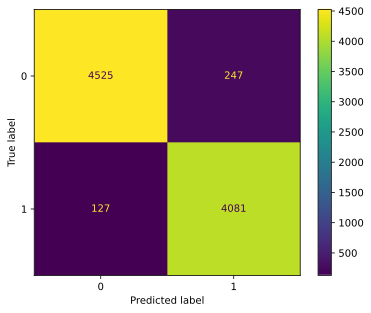

In [ ]:
regressor.plot_confusion_matrix(y_test, save_name=cm + 'logreg.jpg')

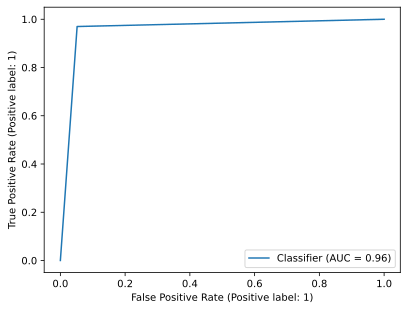

In [ ]:
regressor.plot_roc_curve(y_test, save_name= roc + 'logreg.jpg')

In [ ]:
print(regressor.print_classification_report(y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4772
           1       0.94      0.97      0.96      4208

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [ ]:
regressor.save_model(save_name=models + 'logreg.sav')

In [ ]:
regressor.timeit(X_test)

0.00019986629486083983  s  |   0.19986629486083984  ms  |   199.86629486083984  µs


0.00019986629486083983

In [ ]:
logreg_text = train_model(LogisticRegression(max_iter=1000))

In [ ]:
logreg_text.fit(X_text_train, y_text_train)

In [ ]:
logreg_text.score(X_text_test, y_text_test)

0.9952115812917595

In [ ]:
logreg_text.predict(X_text_test)

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
accuracy_score(logreg_text.predict(X_text_val), y_text_val)

0.9952115812917595

In [ ]:
logreg_text.save_model(save_name = models + 'logregtext.sav')

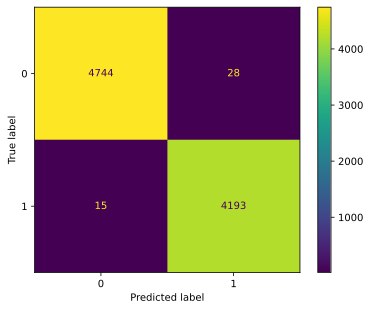

In [ ]:
logreg_text.plot_confusion_matrix(y_text_test, save_name=cm + 'logregtext.jpg')

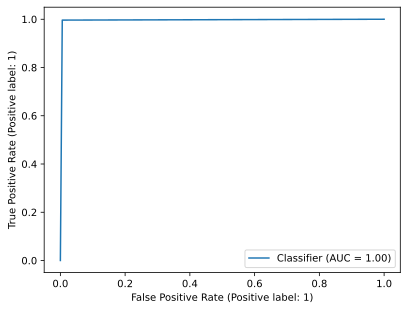

In [ ]:
logreg_text.plot_roc_curve(y_text_test, save_name=roc+'logregtext.jpg')

In [ ]:
print(logreg_text.print_classification_report(y_text_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4772
           1       0.99      1.00      0.99      4208

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
logreg_text.timeit(X_text_test)

0.0003717660903930664  s  |   0.3717660903930664  ms  |   371.7660903930664  µs


0.0003717660903930664

## Decision Tree

In [ ]:
tree = train_model(model=DecisionTreeClassifier())
tree.fit(X_train,y_train)
tree.predict(X_test)
tree.score(X_test, y_test)

0.9105790645879732

In [ ]:
accuracy_score(y_val, tree.predict(X_val))

0.9074610244988864

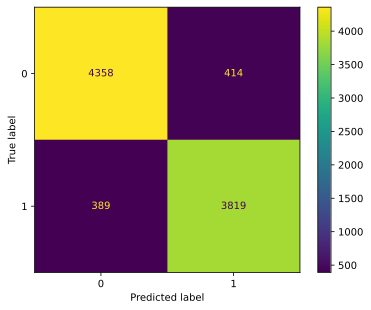

In [ ]:
tree.plot_confusion_matrix(y_test, save_name=cm + 'tree.jpg')

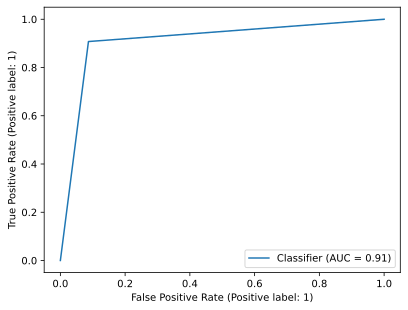

In [ ]:
tree.plot_roc_curve(y_test, save_name= roc + 'tree.jpg')

In [ ]:
print(tree.print_classification_report(y_test))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4772
           1       0.90      0.91      0.90      4208

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980



In [ ]:
tree.timeit(X_test)

0.0003484487533569336  s  |   0.3484487533569336  ms  |   348.4487533569336  µs


0.0003484487533569336

In [ ]:
tree.save_model(save_name=models + 'tree.sav')

In [ ]:
tree_text = train_model(DecisionTreeClassifier())
tree_text.fit(X_text_train, y_text_train)
tree_text.predict(X_text_test)
tree_text.score(X_text_test, y_text_test)

0.9946547884187082

In [ ]:
accuracy_score(y_text_val, tree_text.predict(X_text_val))

0.9943207126948775

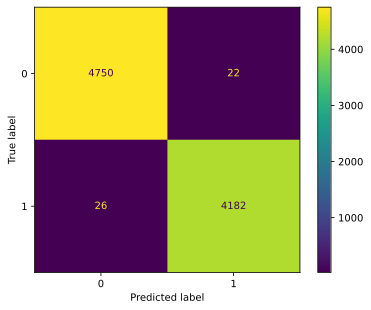

In [ ]:
tree_text.plot_confusion_matrix(y_text_test, save_name = cm + 'treetext.jpg')

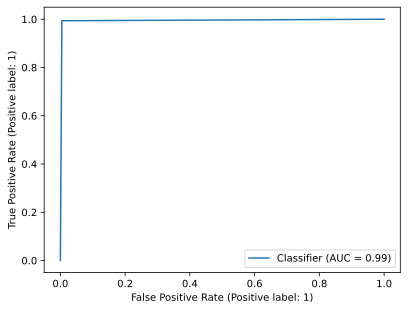

In [ ]:
tree_text.plot_roc_curve(y_text_test, save_name = roc + 'treetext.jpg')

In [ ]:
print(tree_text.print_classification_report(y_text_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4772
           1       0.99      0.99      0.99      4208

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
tree_text.timeit(X_text_test)

0.00038256645202636717  s  |   0.3825664520263672  ms  |   382.5664520263672  µs


0.00038256645202636717

In [ ]:
tree_text.save_model(save_name=models + 'treetext.sav')

## KNN

In [ ]:
knn = train_model(KNeighborsClassifier())
knn.fit(X_train, y_train)
knn.predict(X_test)
knn.score(X_test, y_test)

0.7594654788418709

In [ ]:
accuracy_score(y_val, knn.predict(X_val))

0.766815144766147

In [ ]:
knn.save_model(save_name = models + 'knn.sav')

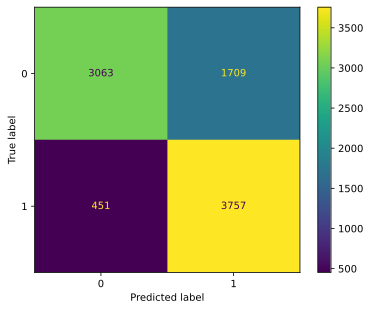

In [ ]:
knn.plot_confusion_matrix(y_test, cm + 'knn.jpg')

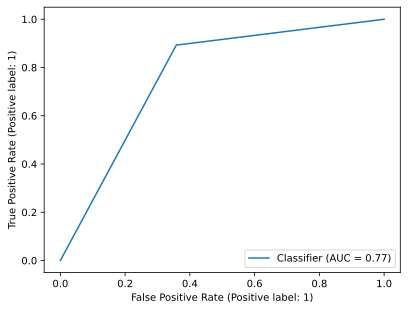

In [ ]:
knn.plot_roc_curve(y_test, roc + 'knn.jpg')

In [ ]:
print(knn.print_classification_report(y_test))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      4772
           1       0.69      0.89      0.78      4208

    accuracy                           0.76      8980
   macro avg       0.78      0.77      0.76      8980
weighted avg       0.79      0.76      0.76      8980



In [ ]:
knn.timeit(X_test)

0.005972528457641601  s  |   5.972528457641602  ms  |   5972.528457641602  µs


0.005972528457641601

In [ ]:
knn_text = train_model(KNeighborsClassifier())
knn_text.fit(X_text_train, y_text_train)
knn_text.predict(X_text_test)
knn_text.score(X_text_test, y_text_test)

0.8975501113585747

In [ ]:
accuracy_score(y_text_val, knn_text.predict(X_text_val))

0.8942093541202673

In [ ]:
knn_text.save_model(save_name= models + 'knntext.sav')

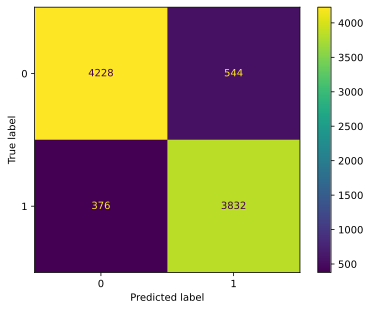

In [ ]:
knn_text.plot_confusion_matrix(y_text_test, save_name= cm + 'knntext.jpg')

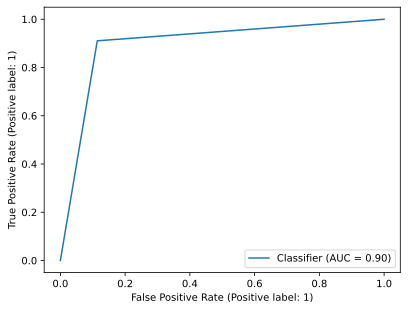

In [ ]:
knn_text.plot_roc_curve(y_text_test, save_name = roc + 'knntext.jpg')

In [ ]:
print(knn_text.print_classification_report(y_text_test))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4772
           1       0.88      0.91      0.89      4208

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980



In [ ]:
knn_text.timeit(X_text_test)

0.07856087684631348  s  |   78.56087684631348  ms  |   78560.87684631348  µs


0.07856087684631348

## Naïve Bayes

In [ ]:
NB = train_model(BernoulliNB())
NB.fit(X_train, y_train)
NB.predict(X_test)
NB.score(X_test, y_test)

0.9520044543429844

In [ ]:
accuracy_score(y_val, NB.predict(X_val))

0.956792873051225

In [ ]:
NB.save_model(save_name= models + 'NB.sav')

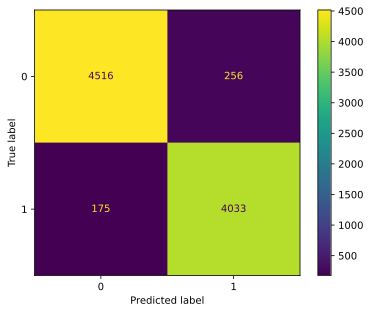

In [ ]:
NB.plot_confusion_matrix(y_test, save_name = cm + 'NB.jpg')

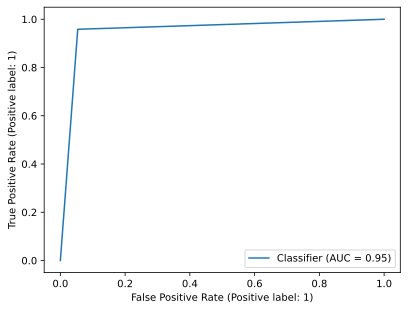

In [ ]:
NB.plot_roc_curve(y_test, save_name = roc + 'NB.jpg')

In [ ]:
print(NB.print_classification_report(y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4772
           1       0.94      0.96      0.95      4208

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [ ]:
NB.timeit(X_test)

0.001777315139770508  s  |   1.7773151397705078  ms  |   1777.3151397705078  µs


0.001777315139770508

In [ ]:
NB_text = train_model(BernoulliNB())
NB_text.fit(X_text_train, y_text_train)
NB.predict(X_text_test)
NB_text.score(X_text_test, y_text_test)

0.9435412026726058

In [ ]:
accuracy_score(y_text_val, NB_text.predict(X_text_val))

0.9446547884187082

In [ ]:
NB_text.save_model(save_name = models + 'NBtext.sav')

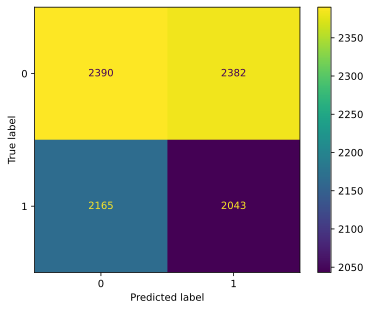

In [ ]:
NB_text.plot_confusion_matrix(y_text_test, save_name = cm + 'NBtext.jpg')

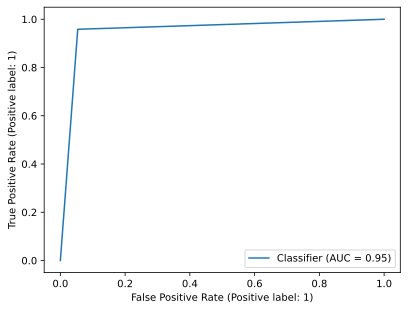

In [ ]:
NB.plot_roc_curve(y_text_test, save_name = roc + 'NBtext.jpg')

In [ ]:
print(NB_text.print_classification_report(y_text_test))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51      4772
           1       0.46      0.49      0.47      4208

    accuracy                           0.49      8980
   macro avg       0.49      0.49      0.49      8980
weighted avg       0.50      0.49      0.49      8980



In [ ]:
NB_text.timeit(X_text_test)

0.0018266201019287109  s  |   1.826620101928711  ms  |   1826.620101928711  µs


0.0018266201019287109

## SVM

In [ ]:
SVM = train_model(SVC())
SVM.fit(X_train, y_train)
SVM.predict(X_test)
SVM.score(X_test, y_test)

0.9585746102449889

In [ ]:
accuracy_score(y_val, SVM.predict(X_val))

0.9621380846325167

In [ ]:
SVM.save_model(save_name = models + 'SVM.sav')

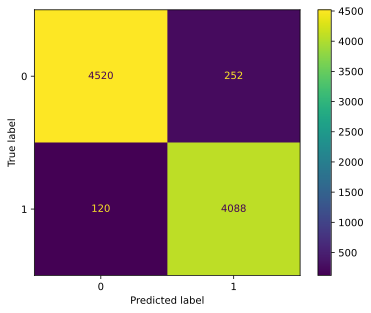

In [ ]:
SVM.plot_confusion_matrix(y_test, save_name = cm + 'SVM.jpg')

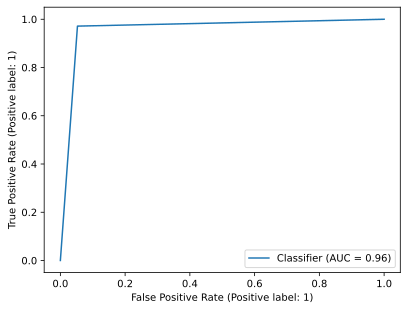

In [ ]:
SVM.plot_roc_curve(y_test, save_name = roc + 'SVM.jpg')

In [ ]:
print(SVM.print_classification_report(y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4772
           1       0.94      0.97      0.96      4208

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [ ]:
SVM.timeit(X_test)

0.0028048276901245115  s  |   2.8048276901245117  ms  |   2804.8276901245117  µs


0.0028048276901245115

In [ ]:
SVM_text = train_model(SVC())
SVM_text.fit(X_text_train, y_text_train)
SVM_text.predict(X_text_test)
SVM_text.score(X_text_test, y_text_test)

0.9924276169265034

In [ ]:
accuracy_score(y_text_val, SVM_text.predict(X_text_val))

0.9926503340757238

In [ ]:
SVM_text.save_model(save_name = models + 'SVM_text.sav')

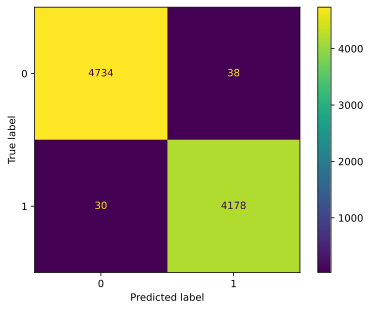

In [ ]:
SVM_text.plot_confusion_matrix(y_text_test, save_name = cm + 'SVM_text.jpg')

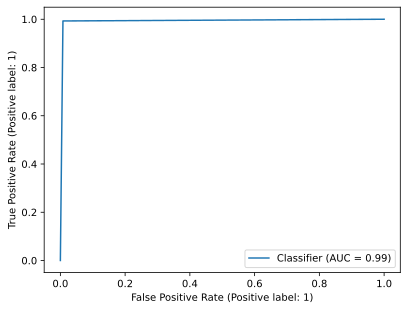

In [ ]:
SVM_text.plot_roc_curve(y_text_test, save_name = roc + 'SVM_text.jpg')

In [ ]:
print(SVM_text.print_classification_report(y_text_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4772
           1       0.99      0.99      0.99      4208

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
SVM_text.timeit(X_text_test)

0.010574412345886231  s  |   10.57441234588623  ms  |   10574.41234588623  µs


0.010574412345886231

# Processing Time

In [ ]:
# device
!uname -a

Linux d96c6093031d 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
!sudo apt install lshw

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids pciutils usb.ids usbutils
The following NEW packages will be installed:
  libpci3 lshw pci.ids pciutils usb.ids usbutils
0 upgraded, 6 newly installed, 0 to remove and 23 not upgraded.
Need to get 820 kB of archives.
After this operation, 3,380 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 pci.ids all 0.0~2020.03.20-1 [217 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libpci3 amd64 1:3.6.4-1ubuntu0.20.04.1 [26.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 lshw amd64 02.18.85-0.3ubuntu2.20.04.1 [271 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 pciutils amd64 1:3.6.4-1ubuntu0.20.04.1 [56.5 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/main amd64 usb.ids all 2020.03.19-1 [176 kB]
Get:6 http://archive.ub

In [ ]:
!sudo lshw

d96c6093031d
    description: Computer
    width: 64 bits
    capabilities: smp vsyscall32
  *-core
       description: Motherboard
       physical id: 0
     *-memory
          description: System memory
          physical id: 0
          size: 12GiB
     *-cpu
          product: Intel(R) Xeon(R) CPU @ 2.20GHz
          vendor: Intel Corp.
          physical id: 1
          bus info: cpu@0
          width: 64 bits
          capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
     *-pci
          description: Host bridge
  

In [ ]:
!sudo lshw -short

H/W path    Device  Class          Description
                    system         Computer
/0                  bus            Motherboard
/0/0                memory         12GiB System memory
/0/1                processor      Intel(R) Xeon(R) CPU @ 2.20GHz
/0/100              bridge         440FX - 82441FX PMC [Natoma]
/0/100/1            bridge         82371AB/EB/MB PIIX4 ISA
/0/100/1.3          bridge         82371AB/EB/MB PIIX4 ACPI
/0/100/3            generic        Virtio SCSI
/0/100/3/0          generic        Virtual I/O device
/0/100/4            network        Virtio network device
/0/100/4/0          network        Virtual I/O device
/0/100/5            generic        Virtio memory balloon
/0/100/5/0          generic        Virtual I/O device
/0/100/6            generic        Virtio RNG
/0/100/6/0          generic        Virtual I/O device
/0/2                system         PnP device PNP0b00
/0/3                input          PnP device PNP0303
/0/4                input  

In [ ]:
import time
import random
def avgTime(model:'Object',test_input:'numpy.ndarray',*, n_iters=10) -> float:
    times = np.empty((n_iters,))
    for _ in range(n_iters):
        idx = random.randint(0,200)
        start = time.time()
        model.predict(test_input[idx])
        end = time.time()
        times[_] = end - start
    print(avgtime:=np.mean(times)," s  |  ", avgtime*1000," ms  |  ", avgtime*1000000, " µs")
    return avgtime

In [ ]:
# logreg - we can finetune using GridSearchCV
avgTime(loaded_model,X_test,n_iters=10)

0.0003972053527832031  s  |   0.3972053527832031  ms  |   397.2053527832031  µs


0.0003972053527832031

In [ ]:
# logreg with text
avgTime(loaded_text_model, X_text_test)

0.00043976306915283203  s  |   0.43976306915283203  ms  |   439.76306915283203  µs


0.00043976306915283203

In [ ]:
# Decision tree
avgTime(loaded_tree,X_test,n_iters=10)
# Decision Tree with text
avgTime(loaded_text_tree, X_text_test)

0.0005131006240844726  s  |   0.5131006240844727  ms  |   513.1006240844727  µs
0.0005401372909545898  s  |   0.5401372909545898  ms  |   540.1372909545898  µs


0.0005401372909545898

In [ ]:
# KNN
avgTime(loaded_knn,X_test,n_iters=10)
# KNN with text
avgTime(loaded_text_knn, X_text_test)

0.005048894882202148  s  |   5.048894882202148  ms  |   5048.894882202148  µs
0.15187408924102783  s  |   151.87408924102783  ms  |   151874.08924102783  µs


0.15187408924102783

In [ ]:
# Naive Bayes
avgTime(loaded_NB,X_test)
# Naive Bayes with text
avgTime(loaded_text_NB, X_text_test)

0.004771304130554199  s  |   4.771304130554199  ms  |   4771.304130554199  µs
0.16091415882110596  s  |   160.91415882110596  ms  |   160914.15882110596  µs


0.16091415882110596

In [ ]:
# SVM
avgTime(loaded_SVM, X_test)
# SVM with text
avgTime(loaded_text_SVM, X_text_test)

0.00459291934967041  s  |   4.59291934967041  ms  |   4592.91934967041  µs
0.16341450214385986  s  |   163.41450214385986  ms  |   163414.50214385986  µs


0.16341450214385986

# Gradio

In [ ]:
# checking the number of samples in the dataset
print((Y_train.shape[0]+Y_test.shape[0])) # 85___ in new dataset

20800


In [ ]:
# installing gradio
!pip install gradio --quiet

In [ ]:
import gradio as gr

def predict(text:list[str]) -> int:
    """
    Returns the predicted output.
    """
    return loaded_model.predict(vectorizer.transform(text))

def output(text:str) -> str:
    """
    Returns output string from based on the prediction.
    """
    if(predict([text]) == 1):
        return "Fake News Bro 😂"
    else:
        return "Correct eh ra p🌺🌺ka"

demo = gr.Interface(fn=output, 
                    inputs=gr.Textbox(lines=2, placeholder="Enter news headline only..."),
                    outputs="text")

demo.launch(debug=True) 

Keyboard interruption in main thread... closing server.


In [ ]:
blocks = gr.Blocks()

with blocks as demo:
    subject = gr.Textbox(placeholder="subject")
    verb = gr.Radio(["ate", "loved", "hated"])
    object = gr.Textbox(placeholder="object")

    with gr.Row():
        btn = gr.Button("Create sentence.")
        reverse_btn = gr.Button("Reverse sentence.")
        foo_bar_btn = gr.Button("Append foo")
        reverse_then_to_the_server_btn = gr.Button(
            "Reverse sentence and send to server."
        )

    def sentence_maker(w1, w2, w3):
        return f"{w1} {w2} {w3}"

    output1 = gr.Textbox(label="output 1")
    output2 = gr.Textbox(label="verb")
    output3 = gr.Textbox(label="verb reversed")
    output4 = gr.Textbox(label="front end process and then send to backend")

    btn.click(sentence_maker, [subject, verb, object], output1)
    reverse_btn.click(
        None, [subject, verb, object], output2, _js="(s, v, o) => o + ' ' + v + ' ' + s"
    )
    verb.change(lambda x: x, verb, output3, _js="(x) => [...x].reverse().join('')")
    foo_bar_btn.click(None, [], subject, _js="(x) => x + ' foo'")

    reverse_then_to_the_server_btn.click(
        sentence_maker,
        [subject, verb, object],
        output4,
        _js="(s, v, o) => [s, v, o].map(x => [...x].reverse().join(''))",
    )

demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


In [ ]:
!pip install transformers --quiet

In [ ]:
!pip install transformers[sentencepiece] --quiet

In [ ]:
import gradio as gr

iface = gr.Interface.load("huggingface/Helsinki-NLP/opus-mt-en-es",
  examples=[["Hello! My name is Omar"]]
)

iface.launch()

Fetching model from: https://huggingface.co/Helsinki-NLP/opus-mt-en-es
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>